In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
import xgboost as xgb


%matplotlib inline 
%config InlineBackend.figure_format = 'png'

In [2]:
train = pd.read_csv("../input/listings.csv")

In [3]:
columns_to_keep = ["price", "neighbourhood_cleansed", "bedrooms",
                   "property_type", "room_type", "name", "summary",
                   "amenities", "latitude", "longitude", "number_of_reviews",
                   "require_guest_phone_verification", "minimum_nights"]

train = train[columns_to_keep]

In [4]:
train.head(3)

,price,neighbourhood_cleansed,bedrooms,property_type,room_type,name,summary,amenities,latitude,longitude,number_of_reviews,require_guest_phone_verification,minimum_nights
0,$250.00,Roslindale,2.0,House,Entire home/apt,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...","{TV,""Wireless Internet"",Kitchen,""Free Parking ...",42.282619,-71.133068,0,f,2
1,$65.00,Roslindale,1.0,Apartment,Private room,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,"{TV,Internet,""Wireless Internet"",""Air Conditio...",42.286241,-71.134374,36,f,2
2,$65.00,Roslindale,1.0,Apartment,Private room,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",42.292438,-71.135765,41,f,3


In [5]:
train.head()

,price,neighbourhood_cleansed,bedrooms,property_type,room_type,name,summary,amenities,latitude,longitude,number_of_reviews,require_guest_phone_verification,minimum_nights
0,$250.00,Roslindale,2.0,House,Entire home/apt,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...","{TV,""Wireless Internet"",Kitchen,""Free Parking ...",42.282619,-71.133068,0,f,2
1,$65.00,Roslindale,1.0,Apartment,Private room,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,"{TV,Internet,""Wireless Internet"",""Air Conditio...",42.286241,-71.134374,36,f,2
2,$65.00,Roslindale,1.0,Apartment,Private room,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",42.292438,-71.135765,41,f,3
3,$75.00,Roslindale,1.0,House,Private room,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,"{TV,Internet,""Wireless Internet"",""Air Conditio...",42.281106,-71.121021,1,f,1
4,$79.00,Roslindale,1.0,House,Private room,Come Home to Boston,"My comfy, clean and relaxing home is one block...","{Internet,""Wireless Internet"",""Air Conditionin...",42.284512,-71.136258,29,f,2


In [6]:
train.tail()

,price,neighbourhood_cleansed,bedrooms,property_type,room_type,name,summary,amenities,latitude,longitude,number_of_reviews,require_guest_phone_verification,minimum_nights
3580,$69.00,Charlestown,1.0,Apartment,Private room,Big cozy room near T,5 min walking to Orange Line subway with 2 sto...,"{Internet,""Wireless Internet"",""Air Conditionin...",42.380968,-71.083795,4,f,2
3581,$150.00,Allston,1.0,Apartment,Private room,BU Apartment DexterPark Bright room,"Most popular apartment in BU, best located in ...","{TV,Internet,""Wireless Internet"",""Air Conditio...",42.347503,-71.118336,0,f,3
3582,$198.00,Charlestown,1.0,Apartment,Entire home/apt,Gorgeous funky apartment,Funky little apartment close to public transpo...,"{""translation missing: en.hosting_amenity_49"",...",42.371771,-71.071300,0,f,3
3583,$65.00,Charlestown,1.0,Apartment,Private room,Great Location; Train and Restaurants,"My place is close to Taco Loco Mexican Grill, ...","{Kitchen,Gym,""Family/Kid Friendly"",Washer,Drye...",42.385226,-71.080923,2,f,1
3584,$65.00,Charlestown,1.0,Apartment,Private room,(K1) Private Room near Harvard/MIT,My place is close to My home is a warm and fri...,"{""Wireless Internet"",Kitchen,Essentials,""trans...",42.387888,-71.080654,0,f,1


In [7]:
train.count()

price                               3585
neighbourhood_cleansed              3585
bedrooms                            3575
property_type                       3582
room_type                           3585
name                                3585
summary                             3442
amenities                           3585
latitude                            3585
longitude                           3585
number_of_reviews                   3585
require_guest_phone_verification    3585
minimum_nights                      3585
dtype: int64

TypeError: '<' not supported between instances of 'str' and 'float'

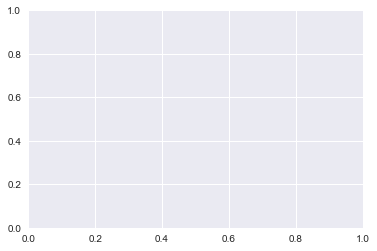

In [8]:
train["price"].hist(bins = 30)
#bins设置条状图的列数

In [9]:
#先要进行格式转换
def clean(train):

    train["bedrooms"] = train["bedrooms"].fillna(0.5) #these are studios
    train["summary"] = train["summary"].fillna("")
    train["bedrooms"] = train["bedrooms"].astype("str")

    #replace unpopular types with other 
    popular_types = train["property_type"].value_counts().head(6).index.values
    train.loc[~train.property_type.isin(popular_types), "property_type"] = "Other"

    #make price numeric:
    train["price"] = train["price"].str.replace("[$,]", "").astype("float")
    #eliminate crazy prices:
    train = train[train["price"] < 600]
    
    return train

train = clean(train)

98.37957922657978

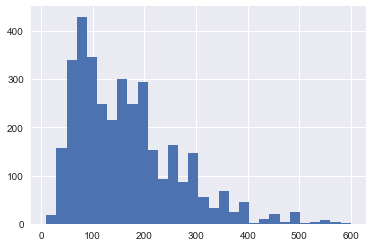

In [10]:
train["price"].hist(bins = 30)
train["price"].std()
#std标准差

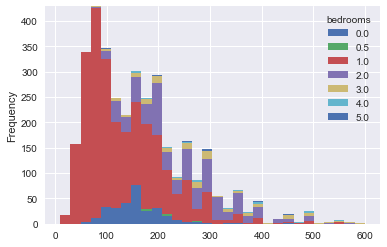

In [11]:
(train.pivot(columns = "bedrooms", values = "price")
         .plot.hist(bins = 30, stacked = True))

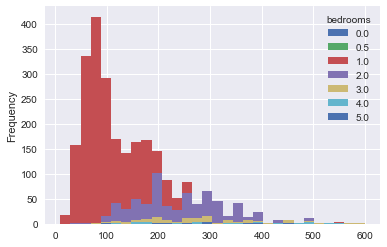

In [35]:
(train.pivot(columns = "bedrooms", values = "price")
         .plot.hist(bins = 30, stacked = False))

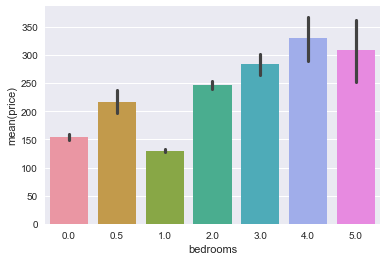

In [12]:
sns.barplot(x = "bedrooms", y = "price", data = train)

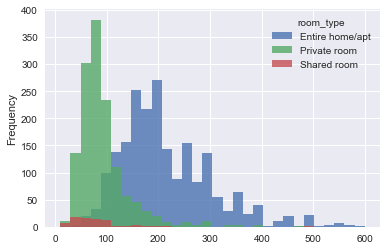

In [13]:
(train.pivot(columns = "room_type", values = "price")
         .plot.hist(bins = 30, stacked = False, alpha = 0.8))
#bins 数据的宽度 alpha 频率分布图的透明度

In [14]:
train.groupby("room_type")["price"].mean()

room_type
Entire home/apt    213.848369
Private room        92.080845
Shared room         84.443038
Name: price, dtype: float64

In [15]:
y = train["price"]
train_num_cat = train[["neighbourhood_cleansed", "bedrooms",
                   "property_type", "room_type", "latitude", "longitude",
                   "number_of_reviews", "require_guest_phone_verification",
                    "minimum_nights"]]

train_text = train[["name", "summary", "amenities"]]

In [16]:
X_num = pd.get_dummies(train_num_cat)

In [17]:
train_text.head()

,name,summary,amenities
0,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...","{TV,""Wireless Internet"",Kitchen,""Free Parking ..."
1,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,"{TV,Internet,""Wireless Internet"",""Air Conditio..."
2,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","{TV,""Cable TV"",""Wireless Internet"",""Air Condit..."
3,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,"{TV,Internet,""Wireless Internet"",""Air Conditio..."
4,Come Home to Boston,"My comfy, clean and relaxing home is one block...","{Internet,""Wireless Internet"",""Air Conditionin..."


In [18]:
train.amenities = train.amenities.str.replace("[{}]", "")

In [19]:
amenity_ohe = train.amenities.str.get_dummies(sep = ",")

In [20]:
train.amenities = train.amenities.str.replace("[{}]", "")
amenity_ohe = train.amenities.str.get_dummies(sep = ",")

In [21]:
amenity_ohe.head(3)

,"""24-Hour Check-in""","""Air Conditioning""","""Buzzer/Wireless Intercom""","""Cable TV""","""Carbon Monoxide Detector""","""Elevator in Building""","""Family/Kid Friendly""","""Fire Extinguisher""","""First Aid Kit""","""Free Parking on Premises""",...,Gym,Hangers,Heating,Internet,Iron,Kitchen,Pool,Shampoo,TV,Washer
0,0,0,0,0,0,0,1,1,0,1,...,0,0,1,0,0,1,0,1,1,1
1,0,1,0,0,1,0,1,1,0,0,...,0,1,1,1,1,1,0,1,1,1
2,0,1,0,1,1,0,0,0,1,1,...,0,0,1,0,0,1,0,1,1,1


In [22]:
amenity_ohe.tail()

,"""24-Hour Check-in""","""Air Conditioning""","""Buzzer/Wireless Intercom""","""Cable TV""","""Carbon Monoxide Detector""","""Elevator in Building""","""Family/Kid Friendly""","""Fire Extinguisher""","""First Aid Kit""","""Free Parking on Premises""",...,Gym,Hangers,Heating,Internet,Iron,Kitchen,Pool,Shampoo,TV,Washer
3580,1,1,0,0,1,0,1,1,0,1,...,0,1,1,1,1,1,0,1,0,0
3581,1,1,0,0,1,1,1,1,0,1,...,1,1,1,1,0,1,0,1,1,1
3582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3583,0,0,0,0,0,0,1,0,0,0,...,1,1,0,0,0,1,0,0,0,1
3584,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [23]:
train["text"] = train["name"].str.cat(train["summary"], sep = " ")

In [24]:
vect = CountVectorizer(stop_words = "english", min_df = 10)
X_text = vect.fit_transform(train["text"])

In [25]:
#metric:
def rmse(y_true, y_pred):
    return(np.sqrt(metrics.mean_squared_error(y_true, y_pred)))

#evaluates rmse on a validation set:
def eval_model(model, X, y, state = 3):
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, random_state = state)
    preds = model.fit(X_tr, y_tr).predict(X_val)
    return rmse(y_val, preds)

In [26]:
(X_num.shape, X_text.shape, amenity_ohe.shape)

((3536, 48), (3536, 1100), (3536, 45))

In [27]:
#this is numeric + amenities:
X = np.hstack((X_num, amenity_ohe))

#this is all of them:
X_full = np.hstack((X_num, amenity_ohe, X_text.toarray()))

In [28]:
models_rmse = [eval_model(xgb.XGBRegressor(), X_num, y),
 eval_model(xgb.XGBRegressor(), X, y),
 eval_model(Ridge(), X_num, y),
 eval_model(Ridge(), X, y)]

In [29]:
models_rmse = pd.Series(models_rmse, index = ["xgb_num", "xgb_ame", "ridge", "ridge_ame"] )

In [30]:
models_rmse

xgb_num      58.786255
xgb_ame      57.516003
ridge        60.078641
ridge_ame    58.446793
dtype: float64

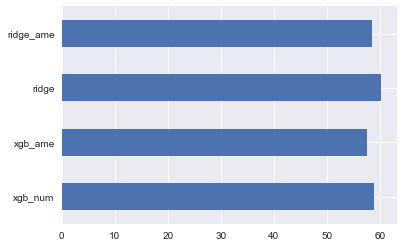

In [31]:
models_rmse.plot(kind = "barh")

In [32]:
results = []
for i in range(30):
    X_tr, X_val, y_tr, y_val = train_test_split(X_num, y)
    y_baseline = [np.mean(y_tr)]*len(y_val)

    model = Ridge(alpha = 5)
    preds_logit = model.fit(X_tr, y_tr).predict(X_val)


    model = xgb.XGBRegressor()  
    preds_xgb = model.fit(X_tr, y_tr).predict(X_val)
    
    results.append((rmse(y_baseline, y_val),
                    rmse(preds_logit, y_val),
                    rmse(preds_xgb, y_val)
                    ))

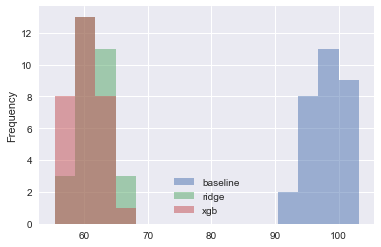

In [33]:
results = pd.DataFrame(results, columns = ["baseline", "ridge", "xgb"])
results.plot.hist(bins = 15, alpha = 0.5)

In [34]:
pd.DataFrame([results.mean(), results.std()])

,baseline,ridge,xgb
0,98.103149,61.915839,60.523343
1,3.002799,2.575671,2.577420
